# Homework 2: SVD and PCA for Machine Learning

## Visualizing dyad.

Consider an image from `skimage.data`. For simplicity, say that $X\in\mathbb{R}^{m\times n}$ is the matrix representing that image. You are asked to visualize the dyad of the SVD Decomposition of X and the result of compressing the image via SVD. In particular:
* Load the image into memory and compute its SVD;
* Visualize some of the dyad $\sigma_i u_iv_i^T$ of this decomposition. What do you notice?
* Plot the singular values of $X$. Do you note something?
* Visualize the $k$-rank approximation of $X$ for different values of $k$. What do you observe?
* Compute and plot the approximation error $\lVert X-X_k\rVert_{F}$ for increasing values of $k$, where $X_k$ is the $k$-rank approximation of $k$.
* Plot the compression factor $c_k=\frac{k(m+n+1)}{mn}$ for increasing $k$. What is the approximation error when the compressed image requires the same amount of informations of those of the uncompressed image (i.e. $c_k=1$)?

In [212]:
import skimage as ski
import numpy as np
import matplotlib.pyplot as plt

X = ski.data.coins()
m, n = X.shape
U, s, VT = np.linalg.svd(X)
S = np.zeros(X.shape)
S[:len(s), :len(s)] = np.diag(s)

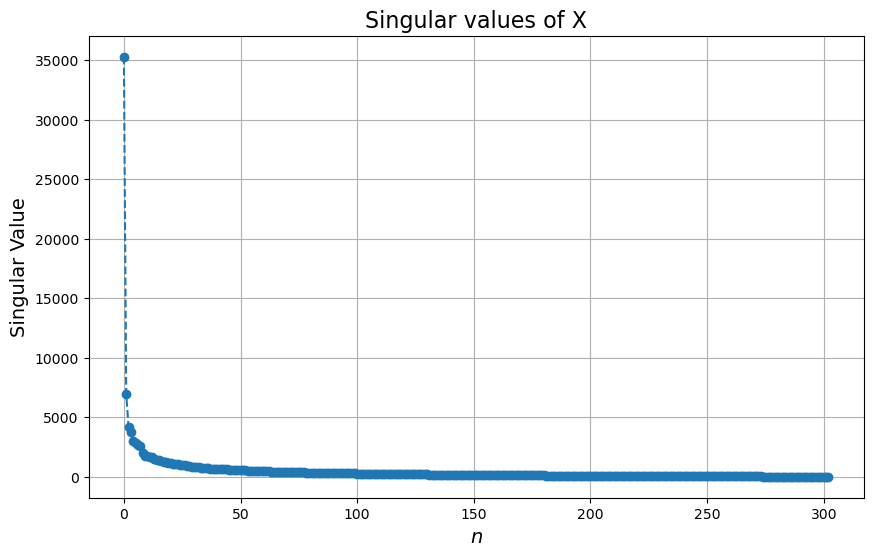

In [213]:
plt.figure(figsize=(10, 6))
plt.plot(s, marker='o', linestyle='--') 
plt.title("Singular values of X", fontsize=16)
plt.xlabel("$n$", fontsize=14)
plt.ylabel("Singular Value", fontsize=14)
plt.grid(True)
plt.show()

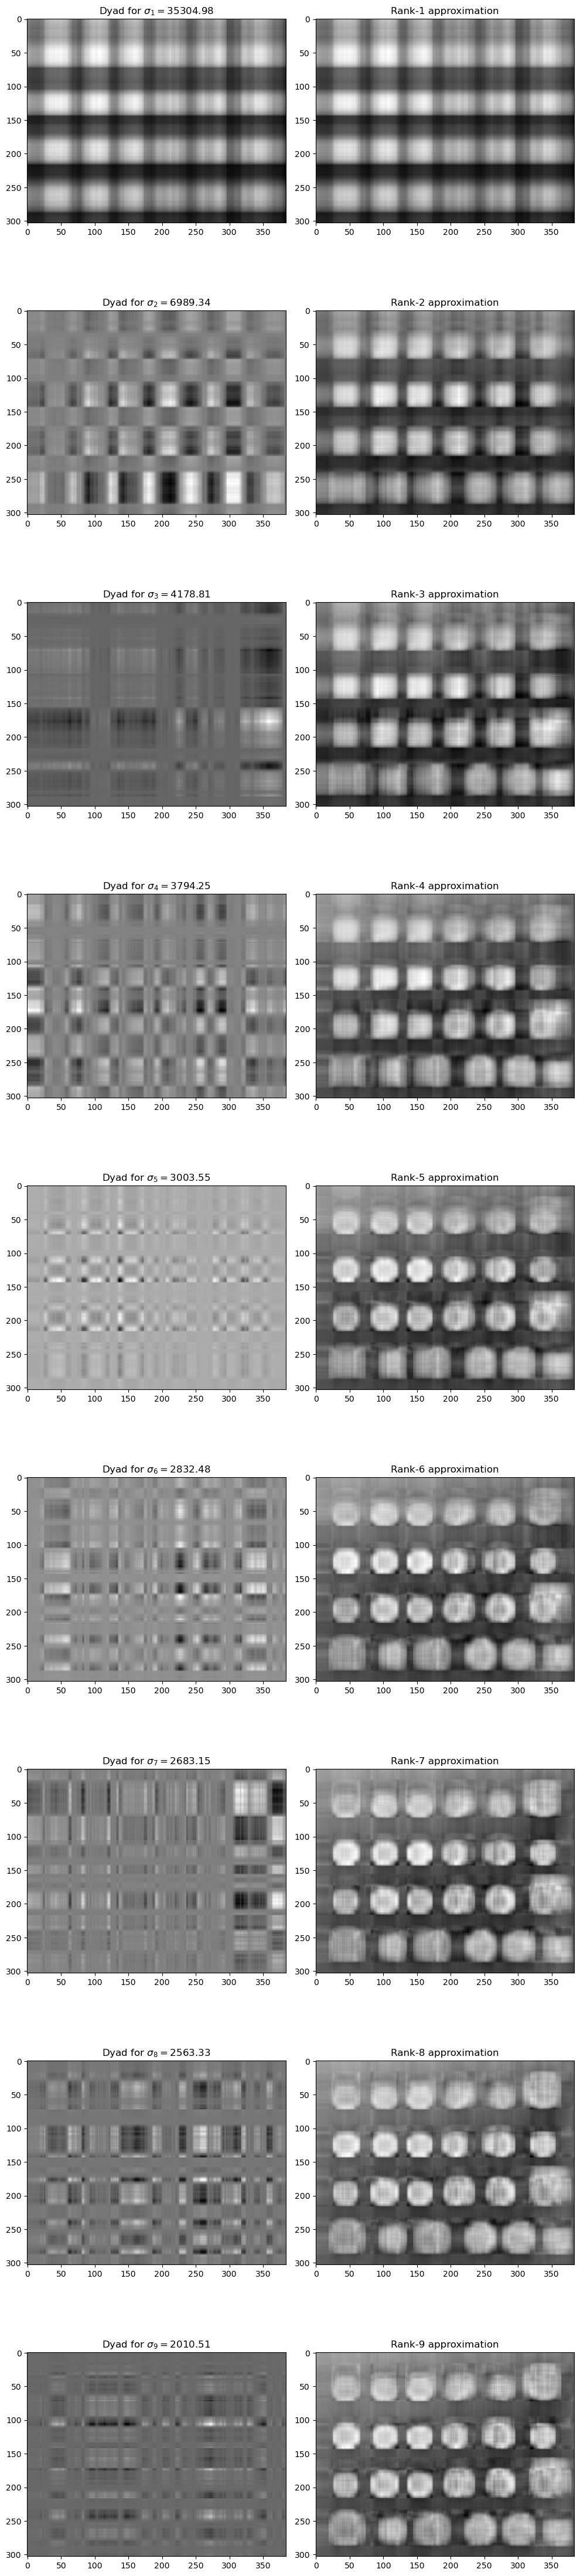

In [214]:
k = 9

dyad_sum = np.zeros_like(X, dtype=np.float32)
approximation_errors = []

fig, axes = plt.subplots(k, 2, figsize=(10, 5*k))

for i in range(k):
    dyad = (U[:, i][:, np.newaxis] * s[i]) @ VT[i, :][np.newaxis, :]
    dyad_sum += dyad
    approximation_errors.append(np.linalg.norm(X - dyad_sum))

    axes[i, 0].imshow(dyad, cmap='gray')
    axes[i, 0].set_title(f"Dyad for $\\sigma_{i+1} = {s[i]:.2f}$")

    axes[i, 1].imshow(dyad_sum, cmap='gray')
    axes[i, 1].set_title(f"Rank-{i+1} approximation")

plt.tight_layout()
plt.show()

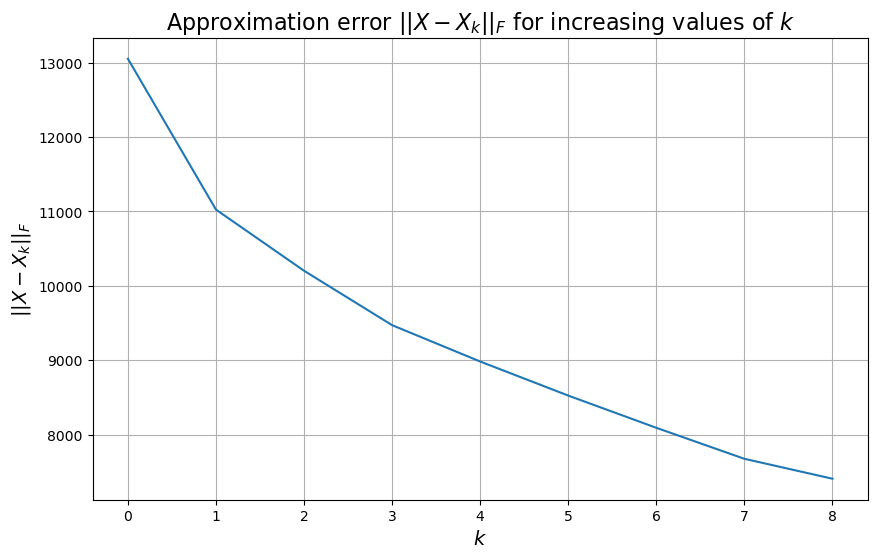

In [215]:
plt.figure(figsize=(10, 6))
# plt.plot(s, marker='o', linestyle='--') 
plt.title("Approximation error $||X-X_k||_F$ for increasing values of $k$", 
          fontsize=16)
plt.xlabel("$k$", fontsize=14)
plt.ylabel("$|| X-X_k||_F$", fontsize=14)
plt.plot(approximation_errors)
plt.grid(True)
plt.show()

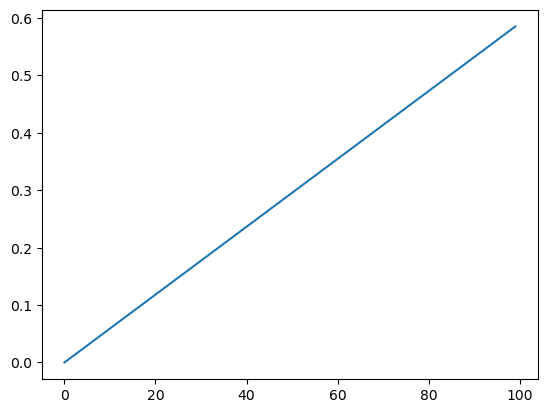

In [216]:
def compression_factor(k, m, n):
    return (k * (m + n + 1)) / (m * n)

c_k = [compression_factor(k, m, n) for k in range(0, 100)]

plt.plot(c_k)
plt.show()

## Classification of MNIST Digits with SVD Decomposition.

The task for this exercise is to learn the classification of MNIST digits by using SVD decomposition. Remember that, Given a matrix $X\in\mathbb{R}^{m\times n}$ and its SVD decomposition $X=USV^T$ we can prove that an orthogonal base for the space of the columns is given by the first $p$ columns of the matrix $U$, where $p=\text{rank}(X)$ is equal to the number of non-zero singular values of $S$.

We will make use of the space of the culumns defined by the $U$ matrix and the following Theorem:

**Theorem 1.** *Let's consider $W$ a subspace of $\mathbb{R}^n$ where $\dim W=s$ and $\{w_1,\ldots,w_s\}$ an orthogonal base of $W$. Given a generic $y\in\mathbb{R}^n$ we have that the projection $y^{\perp}$ of $y$ onto $W$ has the following form:*

$$y^{\perp}=\frac{y\cdot w_1}{w_1\cdot w_1}w_1+\cdots+\frac{y\cdot w_s}{w_s\cdot w_s}w_s$$

**Corollary 1.1.** *If $X\in\mathbb{R}^{m\times n}$ is a given matrix with SVD decomposition $X=USV^T$, since the $p=\text{rank}(X)$ is the dimension of the space defined by the columns of $X$ and the columns of $U$, $\{u_1,\ldots,u_op\}$ are an orthonormal basis for that space, the projection of an $n$-dimensional vector $y$ on this space can be easily computed as:*

$$y^{\perp}=U(U^Ty)$$

Thus, consider a binary classification problem, where we want to classificate if a given digit of dimension $m\times n$ represents the number 3 or the number 4. We will call refer to the class of the number 3 as $C_1$, and to the class of the numer 4 as $C_2$. Suppose that $s_1$ is the number of elements in $C_1$, while $s_2$ is the number of elements in $C_2$.

### 1. In the first exercise, we will implement the binary classification algorithm for the digits 3 and 4 of MNIST following the ideas explained above.
* Load the MNIST dataset container in `./data/MNIST.mat` with the function `scipy.io.loadmat`. This dataset, which is loaded in the form of a $256\times1707$ matrix $X$, contains the flattenened version of 1707 $16\times 16$ grayscale handwritten digits. Moreover, from the same file it is possible to load a vector $I$ of length 1707 such that the $i$-th element of $I$ is the true digit represented by the $i$-th image of $X$.
* Visualize a bunch of datapoints of X with the function `plt.imshow`.
* Extract from $X$ those columns that corresponds to digits 3 or 4. Those digits represents the classes $C_1$ and $C_2$ defined above.
* Split the obtained dataset in training and testing. From now on, we will only consider the training set. The test set will be only used at the end of the exercise to test the algorithm.
* Create the matrices $X_1$ and $X_2$ defined above from $X$.
* Compute the SVD decomposition of $X_1$ and $X_2$ with `np.linalg.svd(matrix, full_matrices=False)` and denote the $U$-part of the two decompositions as $U_1$ and $U_2$.
* Take an unknown digit $y$ from the test set, and compute $y_{1}^{\perp}=U_1(U_1^Ty)$ and $y_2^{\perp}=U_2(U_2^Ty)$.
* Compute the distances $d_1=||y-y_{1}^{\perp}||_2$ and $d_2=||y-y_{2}^{perp}||_2$ and classify $y$ to $C_1$ if $d_1<d_2$ and to $C_2$ if $d_2<d_1$.
* Repeat the experiment for different values of $y$ in the test set. Compute the missclassification number for this algorithm.
  $$Acc(f_{\theta})=\frac{1}{N_{test}}\sum_{i=1}^{N_{test}}\ell(f_{\theta}(x_1,k_{x_i}))$$
  with
  $$\ell(f_{\theta}(x),k_x)=
  \begin{cases}
      1 & \text{if }f_{\theta}(x)\neq k_x \\ 
      0 & \text{if }f_{\theta}(x)=k_x
  \end{cases}
  $$
* Repeat the experiment for different digits other than 3 or 4. There is a relationship between the visual similarity of the digits and the classification error?
* Comment the obtained results.

In [309]:
import pandas as pd

data = pd.read_csv('data.csv')

print(f"Shape of the data: {data.shape}")
print("")
data.head()

Shape of the data: (42000, 785)



,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [310]:
data = np.array(data)

X = data[:, 1:]
Y = data[:, 0]
X = X.T
print(f"Shape of the data: {X.shape}")

Shape of the data: (784, 42000)


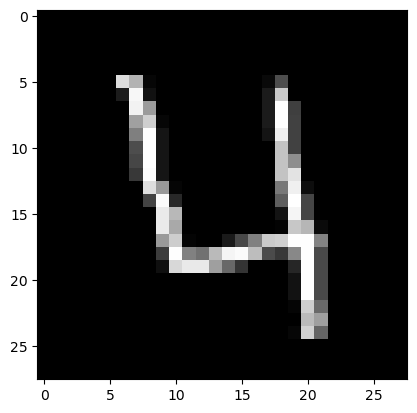

The associated digit is: 4


In [311]:
def visualize(X, idx):
    # Extract the row corresponding to the given index 'idx' from 'X'.
    # The row is flattened and has a shape of (784,).
    flattened_img = X[:, idx]

    # Reshape the flattened image into a 28x28 2D array to prepare for visualization.
    img_reshaped = np.reshape(flattened_img, (28, 28))

    plt.imshow(img_reshaped, cmap='gray')
    plt.show()

idx = 3
visualize(X, idx)
print(f"The associated digit is: {Y[idx]}")

In [312]:
def split_data(X, Y, train_size):
    _, N = X.shape
    train_size = int(train_size * N / 100)

    idx = np.arange(N)
    np.random.shuffle(idx)

    train_idx = idx[:train_size]
    test_idx = idx[train_size:]

    Xtrain = X[:, train_idx]
    Ytrain = Y[train_idx]

    Xtest = X[:, test_idx]
    Ytest = Y[test_idx]

    return (Xtrain, Ytrain), (Xtest, Ytest)
    
(Xtrain, Ytrain), (Xtest, Ytest) = split_data(X, Y, 80)

In [313]:
C1, C2 = (Ytrain == 3), (Ytrain == 4)
X1, X2 = Xtrain[:, C1], Xtrain[:, C2]
print(f"Shape of X1: {X1.shape}")
print(f"Shape of X2: {X2.shape}")

Shape of X1: (784, 3464)
Shape of X2: (784, 3277)


In [314]:
U1, s1, VT1 = np.linalg.svd(X1, full_matrices=False)
U2, s2, VT2 = np.linalg.svd(X2, full_matrices=False)

In [349]:
def binary_classification(X, idx):
    y = X[:,idx]
    y1 = U1 @ (U1.T @ y)
    y2 = U2 @ (U2.T @ y)
    d1 = np.linalg.norm(y-y1)
    d2 = np.linalg.norm(y-y2)
    return 3 if d1 < d2 else 4

In [391]:
mask = (Ytest == 3) | (Ytest == 4)
filtered_Xtest = Xtest[:, mask]
filtered_Ytest = Ytest[mask]


error = evaluate_misclassification_rate(filtered_Xtest, filtered_Ytest, binary_classification)
print(f"Missclassification Rate: {error}")

Missclassification Rate: 0.03745541022592152.3f


Classification for different digits other than 3 or 4:

In [397]:
def test_random_sample(X, Y, classification_func):
    _, n = Xtest.shape
    random_digit = np.random.randint(0, n)

    print(f"The real digit is: {Ytest[random_digit]}")
    print(f"The predicted digit is: {classification_func(Xtest, random_digit)}")

test_random_sample(Xtest, Ytest, binary_classification)

The real digit is: 3
The predicted digit is: 3


### 2. The extension of this idea to the multiple classification task is trivial. Indeed, if we have more than 2 classes (say, $k$ different classes) $C_1,\ldots,C_k$ we just need to repeat the same procedure as before for each matrix $X_1,\ldots,X_k$ to obtain the distances $d_1,\ldots,d_k$. Then, the new digit $y$ will be classified as $C_i$ if $d_i$ is lower that $d_j$ for each $j = 1,\ldots,k$.
Repeat the exercise above with a 3-digit example. Comment the differences.

In [413]:
class MultiClassSVDClassifier:
    def __init__(self, Ytrain, Xtrain, selected_digits=None):
        if selected_digits is None:
            self.digits = list(set(Ytrain))
        else:
            self.digits = selected_digits

        self.C_list, self.X_list, self.U_list = self.prepare_data(Ytrain, Xtrain)

    def prepare_data(self, Ytrain, Xtrain):
        C_list = []
        X_list = []
        U_list = []
        for digit in digits:
            mask = (Ytrain == digit)
            C_list.append(mask)
            
            filtered_Xtrain = Xtrain[:, mask]
            X_list.append(filtered_Xtrain)
            
            U, _, _ = np.linalg.svd(filtered_Xtrain, full_matrices=False)
            U_list.append(U)
        return C_list, X_list, U_list

    def multiclass_classification(self, X, idx):
        y = X[:, idx]
        distances = []
    
        for U in self.U_list:
            y_proj = U @ (U.T @ y)
            d = np.linalg.norm(y - y_proj)
            distances.append(d)
    
        min_distance_idx = np.argmin(distances)
        return self.digits[min_distance_idx]

    def evaluate_misclassification_rate(self, Xtest, Ytest):
        n = Xtest.shape[1]
        y_pred = [self.multiclass_classification(Xtest, i) for i in range(n)]
        incorrect_predictions = sum(Ytest != y_pred)
        missclassification_error = incorrect_predictions / n
        return missclassification_error

multiclassifier = MultiClassSVDClassifier(Ytrain, Xtrain)
print(f"Missclassification Rate: {multiclassifier.evaluate_misclassification_rate(Xtest, Ytest)}")

Missclassification Rate: 0.24833333333333332


In [414]:
test_random_sample(Xtest, Ytest, classifier.multiclass_classification)

The real digit is: 3
The predicted digit is: 3


## Clustering with PCA

The task for this exercise is to verify the ability of PCA in clustering data by projecting very high-dimensional datapoints to 2 or 3 dimensions. In particular, consider the dataset MNIST provided on Virtuale. This dataset contains images of handwritten digits with dimension 28 × 28, together with a number from 0 to 9 representing the label. You are asked to:

* Load the dataset in memory and explore its `head` and `shape` to understand how the informations are placed inside of it;
* Split the dataset into the $X$ matrix of dimension $d\times N$, with $d = 784$ being the dimension of each datum, $N$ is the number of datapoints, and $Y\in\mathbb{R}^N$ containing the corresponding labels;
* Choose a number of digits (for example, 0, 6 and 9) and extract from $X$ and $Y$ the sub-dataset containing only the considered digits. Re-call $X$ and $Y$ those datasets, since the originals are not required anymore;